# Preprocessing of the Caber Dataset

This notbeook loads the Caber VTEM max survey from the CSV files and writes in the data structre used by the CoFI wrapper for PyP223, More importantly it tests the system configuration in an area of the survey where the background model is near constant that is a half space ressitvity of about $1000 \mathrm{\ \Omega m}$, to verify if the setup is correct.

### References

Prikhodko, A., Morrison, E., Bagrianski, A., Kuzmin, P., Tishin, P., & Legault, J. (2010). Evolution of VTEM? technical solutions for effective exploration. ASEG Extended Abstracts, 2010(1), 1-4.


<!-- Please leave the cell below as it is -->

[![Open In Colab](https://img.shields.io/badge/open%20in-Colab-b5e2fa?logo=googlecolab&style=flat-square&color=ffd670)](https://colab.research.google.com/github/inlab-geo/cofi-examples/blob/main/examples/airborne_em/airborne_em_caber_dataset.ipynb)

<!-- Again, please don't touch the markdown cell above. We'll generate badge 
     automatically from the above cell. -->

<!-- This cell describes things related to environment setup, so please add more text 
     if something special (not listed below) is needed to run this notebook -->

> If you are running this notebook locally, make sure you've followed [steps here](https://github.com/inlab-geo/cofi-examples#run-the-examples-with-cofi-locally)
to set up the environment. (This [environment.yml](https://github.com/inlab-geo/cofi-examples/blob/main/envs/environment.yml) file
specifies a list of packages required to run the notebooks)

In [1]:
# -------------------------------------------------------- #
#                                                          #
#     Uncomment below to set up environment on "colab"     #
#                                                          #
# -------------------------------------------------------- #

# !pip install -U cofi
# !pip install git+https://github.com/JuergHauser/PyP223.git


In [2]:
# !git clone https://github.com/inlab-geo/cofi-examples.git
# %cd cofi-examples/examples/airborne_em

In [3]:
import numpy
import pandas
import matplotlib.pyplot as plt
import cofi
import pickle
import json
from forward_lib import (
    problem_setup, 
    system_spec,
    survey_setup, 
    true_model, 
    ForwardWrapper, 
    plot_transient, 
    plot_plate_faces, 
    plot_plate_faces_single,
    plot_survey_map,
    plot_observed_profile,
    get_subset_of_survey
)

numpy.random.seed(42)

## Read CSV files

**Read data from files**

In [4]:
waveform = pandas.read_csv("../../data/airborne_em_caber/Caber_Waveform_Final.csv")

print(waveform.shape)
waveform.head()

(3201, 2)


,Time,TX_Current
0,0.000000,0.351242
1,0.005208,0.584812
2,0.010417,0.916027
3,0.015625,1.356280
4,0.020833,1.908350


In [5]:
survey = pandas.read_csv("../../data/airborne_em_caber/Caber_26-10-2012_Final.csv")
caber = survey.loc[(survey['x'] >= 709100) & (survey['y'] <= 5515000)]

print(caber.shape)
caber.head()

(5726, 210)


,BFx[0],BFx[1],BFx[2],BFx[3],BFx[4],BFx[5],BFx[6],BFx[7],BFx[8],BFx[9],...,SFz[43],SFz[44],SFz[45],SFz[46],SFz[47],SFz[48],SFz[49],x,y,z
11555,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.028266e-05,0.000154,0.000121,-0.000034,0.000019,NaN,NaN,709369.992210,5.512354e+06,391.774920
11556,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.890258e-05,0.000155,0.000129,-0.000039,0.000025,NaN,NaN,709372.239799,5.512356e+06,391.933380
11557,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.561633e-06,0.000156,0.000137,-0.000042,0.000033,NaN,NaN,709374.484443,5.512359e+06,392.089797
11558,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-4.981635e-07,0.000158,0.000145,-0.000043,0.000042,NaN,NaN,709376.726018,5.512361e+06,392.244661
11559,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-8.034243e-06,0.000161,0.000152,-0.000043,0.000052,NaN,NaN,709378.964488,5.512364e+06,392.398422


In [6]:
# read time windows from readme file
index = []
middle = []
start = []
end = []
width = []
readme = open("../../data/airborne_em_caber/CaberNorth_readme.txt", "r")

for lino, line in enumerate(readme.readlines()):
    if lino >= 110 and lino <= 143:
        index.append(int(line.split()[0]))
        middle.append(float(line.split()[1]))
        start.append(float(line.split()[2]))
        end.append(float(line.split()[3]))
        width.append(float(line.split()[4]))

windows = pandas.DataFrame(data={'Index':index,'Middle':middle,'Start':start,'End':end,'Width':width})

print(windows.shape)
windows.head()

(34, 5)


,Index,Middle,Start,End,Width
0,14,96.0,90.0,103.0,13.0
1,15,110.0,103.0,118.0,15.0
2,16,126.0,118.0,136.0,18.0
3,17,145.0,136.0,156.0,20.0
4,18,167.0,156.0,179.0,23.0


We organise the data observations into a 1D array that looks like:

```
[transmitter_0_gate_0, transmitter_0_gate_1, ..., transmitter_0_gate_m, 
 transmitter_1_gate_0, transmitter_1_gate_1, ..., transmitter_1_gate_m, 
 ...
 transmitter_n_gate_0, transmitter_n_gate_1, ..., transmitter_n_gate_m]
```

In [7]:
data_x = windows["Middle"].to_numpy() * 1e-6
data_obs = []

for i in range(0, caber.shape[0]):     # for each transmitter
    for j in range(14, 48):         # for each mid time of gate
        data_obs.append(caber.iloc[i][f"SFz[{j}]"])

data_obs = numpy.array(data_obs)
data_obs[data_obs < 0.0000001] = 0.0000001

**Problem and system specification**

In [8]:
swx = waveform["Time"].to_numpy() * 1e-3

topn = (windows["Start"].to_numpy() * 1e-3+5.7)*1e-3
tcls = (windows["End"].to_numpy() * 1e-3+5.7)*1e-3

_system_spec = {
    "nsx": len(swx), 
    "nchnl": len(topn), 
    "swx": swx, 
    "waveform": waveform["TX_Current"].to_numpy(), 
    "topn": topn, 
    "tcls": tcls,
    "ncmp": 2, 
    "cmp": 2, 
    "ntrn": 4, 
    "txarea": 962.11, 
    "ampt": 0
}

In [9]:
system_spec['topn']=_system_spec['topn']
system_spec['tcls']=_system_spec['tcls']
#system_spec['swx']=_system_spec['swx'][:-1]
#system_spec['waveform']=_system_spec['waveform'][:-1]
system_spec['ntrn']=_system_spec['ntrn']
system_spec['txarea']=_system_spec['txarea']
system_spec['nsx'] =len(system_spec['swx']) 
system_spec['nchnl']= len(system_spec['topn'])

In [10]:
problem_setup = {
    "nlyr": 2,                                  # number of layers (icl. halfspace)
    "nstat": 1,                                 # numebr of fiducials/stations
    "nplt": 1,                                  # number of thin plates
    "cellw": 25,                                # cell width
    "pthk": numpy.array([1]),                   # plates thickness
    "plng": numpy.deg2rad(numpy.array([0])),    # plates plunge (orientation)
}

In [11]:
# sort out transmitter locations and ids
n_fiducials = caber.shape[0]
fiducial_id = numpy.arange(n_fiducials)
tx = caber.x.to_numpy()
ty = caber.y.to_numpy()
tz = caber.radarb.to_numpy()

# assign line id to each line of transmitter
caber_diff = caber["x"].diff().abs() + caber["y"].diff().abs()
line_breakpoints = caber_diff[caber_diff>10].index
caber = caber.assign(line_id=0)
line_id = 0
for idx in reversed(line_breakpoints):
    caber.loc[caber.index > idx, "line_id"] += 1

survey_setup = {
    "tx": tx,                                                   # transmitter easting/x-position
    "ty": ty,                                                   # transmitter northing/y-position
    "tz": tz,                                                   # transmitter height/z-position
    "tazi": numpy.deg2rad(numpy.array([90]*n_fiducials)),    # transmitter azimuth
    "tincl": numpy.deg2rad(numpy.array([6]*n_fiducials)),    # transmitter inclination
    "rx": tx,                                                   # receiver easting/x-position
    "ry": ty,                                                   # receiver northing/y-position
    "rz": tz,                                                   # receiver height/z-position
    "trdx": numpy.array([0]*n_fiducials),                    # transmitter receiver separation inline
    "trdy": numpy.array([0]*n_fiducials),                    # transmitter receiver separation crossline
    "trdz": numpy.array([0]*n_fiducials),                    # transmitter receiver separation vertical
    "fiducial_id": fiducial_id,                                 # unique id for each transmitter
    "line_id": caber["line_id"].to_numpy()          # id of line for each transmitter
}

In [12]:
model_params = {
    "res": numpy.array([1500., 1500.]),        
    "thk": numpy.array([5.]), 
    "peast": numpy.array([175]), 
    "pnorth": numpy.array([100]), 
    "ptop": numpy.array([30]), 
    "pres": numpy.array([0.1]), 
    "plngth1": numpy.array([100]), 
    "plngth2": numpy.array([100]), 
    "pwdth1": numpy.array([0.1]), 
    "pwdth2": numpy.array([90]), 
    "pdzm": numpy.array([75]),
    "pdip": numpy.array([60])
}

## Visualise survey

5726


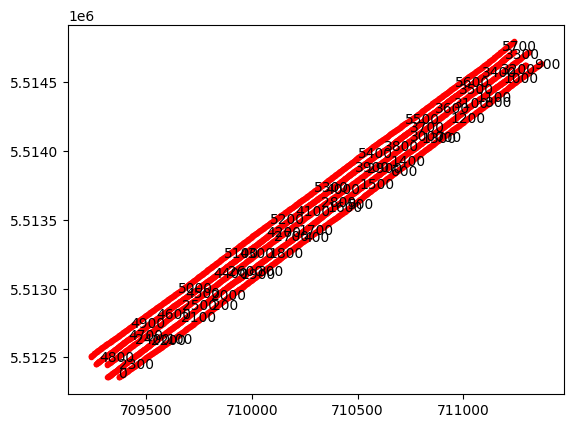

In [13]:
plot_survey_map(survey_setup)
print(n_fiducials)

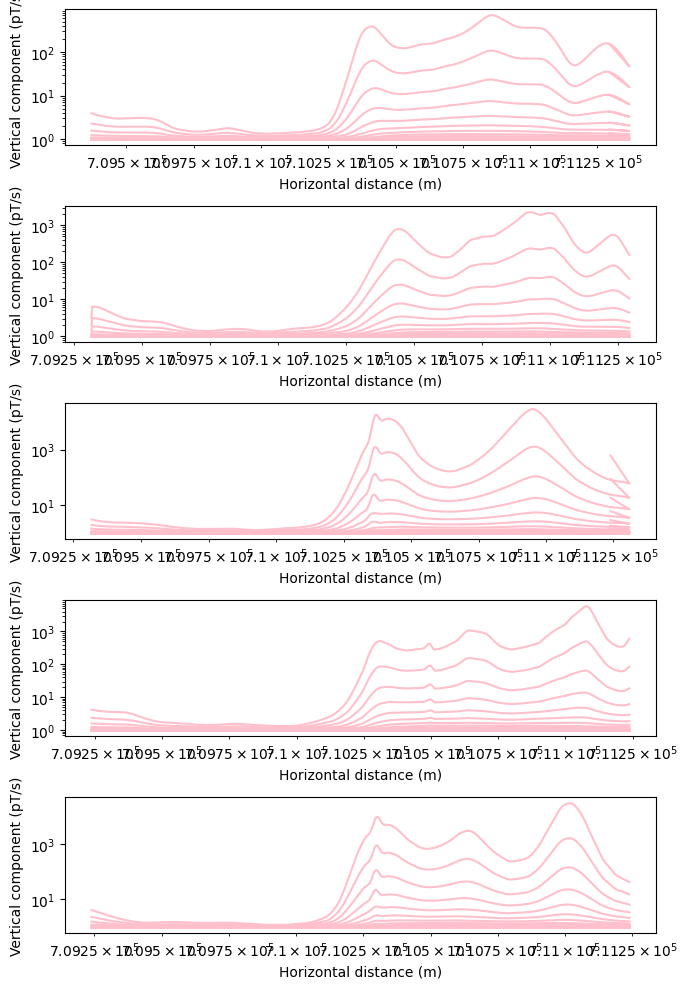

In [14]:
_, axes = plt.subplots(5, 1, figsize=(7, 10))

for i in range(5):
    plot_observed_profile(survey_setup, data_obs, label="observed data", gate_idx=numpy.arange(0, 34, 1), 
                              line_id=[i], ax=axes[i], color="pink")
plt.tight_layout()

## Test the system specficiation for a fiducial at the western end of the survey

In [15]:
survey_setup, system_spec, data_obs = get_subset_of_survey(
    survey_setup, system_spec, data_obs, gate_idx=None,fiducial_id=[1,2]
)

In [16]:
forward = ForwardWrapper(model_params, problem_setup, system_spec, survey_setup, 
                         [ "peast"], data_returned=["vertical"])
true_param_value=[0]

['peast']


In [17]:
data_pred_true = forward(true_param_value)


In [18]:
numpy.exp(data_pred_true[0:len(topn)])

array([1.63442630e+07, 7.30432700e+06, 3.06103550e+06, 1.20567150e+06,
       4.50366188e+05, 1.83619641e+05, 9.85976875e+04, 6.21901797e+04,
       4.23962852e+04, 2.93663867e+04, 2.03702930e+04, 1.47925928e+04,
       1.10957920e+04, 8.41523438e+03, 6.43426562e+03, 4.95692383e+03,
       3.82398267e+03, 2.95795850e+03, 2.26658789e+03, 1.72123682e+03,
       1.31768457e+03, 9.97554810e+02, 7.49256897e+02, 5.62382996e+02,
       4.27447784e+02, 3.32083557e+02, 2.30800674e+02, 1.65942413e+02,
       1.10566826e+02, 9.05753555e+01, 5.00674744e+01, 2.72153091e+01,
       1.32582741e+01, 1.39340725e+01])

In [19]:
data_obs[0:len(topn)]

array([1.35724962e+00, 8.23045194e-01, 4.47916478e-01, 2.13777572e-01,
       8.93230513e-02, 3.08316387e-02, 9.60391574e-03, 3.85056366e-03,
       1.69099786e-03, 1.50642230e-03, 1.70997449e-03, 1.66976091e-03,
       1.35365746e-03, 1.38193101e-03, 1.30885036e-03, 1.30085472e-03,
       1.08609197e-03, 9.18079109e-04, 8.58112006e-04, 9.26631386e-04,
       6.28030975e-04, 4.33078967e-04, 3.30689683e-04, 1.74594912e-04,
       2.14299638e-04, 2.77468265e-04, 1.89219281e-04, 3.37651058e-04,
       1.06550506e-04, 1.89025795e-05, 1.54652036e-04, 1.28913613e-04,
       1.00000000e-07, 2.52482841e-05])

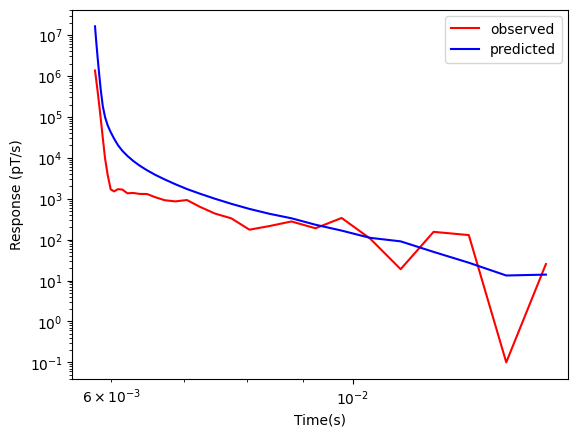

In [20]:
plt.plot((topn+tcls)/2.0,data_obs[0:len(topn)]*1e6,'r',label='observed')
plt.plot((topn+tcls)/2.0,numpy.exp(data_pred_true[0:len(topn)]),'b',label='predicted')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Time(s)')
plt.ylabel('Response (pT/s)')
plt.legend()

## Extract data in the vicinity of the thin plate target

In [21]:
#caber = survey.loc[( survey['x']>709800)  &  (survey['x']<710600)  & (survey['y']>5513100)  &  (survey['y']<5513900)]


xc=710200
yc=5513450
dx=200
dy=200
caber = survey.loc[( survey['x']>xc-dx)  &  (survey['x']<xc+dx)  & (survey['y']>yc-dy)  &  (survey['y']<yc+dy)]

data_x = windows["Middle"].to_numpy() * 1e-6
data_obs = []

for i in range(0, caber.shape[0]):     # for each transmitter
    for j in range(14, 48):         # for each mid time of gate
        data_obs.append(caber.iloc[i][f"SFz[{j}]"])

data_obs = numpy.array(data_obs)
data_obs[data_obs < 0.0000001] = 0.0000001

# sort out transmitter locations and ids
n_fiducials = caber.shape[0]
fiducial_id = numpy.arange(n_fiducials)
tx = caber.x.to_numpy()
ty = caber.y.to_numpy()
tz = caber.radarb.to_numpy()

# assign line id to each line of transmitter
caber_diff = caber["x"].diff().abs() + caber["y"].diff().abs()
line_breakpoints = caber_diff[caber_diff>10].index
caber = caber.assign(line_id=0)
line_id = 0
for idx in reversed(line_breakpoints):
    caber.loc[caber.index > idx, "line_id"] += 1

survey_setup = {
    "tx": tx,                                                   # transmitter easting/x-position
    "ty": ty,                                                   # transmitter northing/y-position
    "tz": tz,                                                   # transmitter height/z-position
    "tazi": numpy.deg2rad(numpy.array([90]*n_fiducials)),    # transmitter azimuth
    "tincl": numpy.deg2rad(numpy.array([6]*n_fiducials)),    # transmitter inclination
    "rx": tx,                                                   # receiver easting/x-position
    "ry": ty,                                                   # receiver northing/y-position
    "rz": tz,                                                   # receiver height/z-position
    "trdx": numpy.array([0]*n_fiducials),                    # transmitter receiver separation inline
    "trdy": numpy.array([0]*n_fiducials),                    # transmitter receiver separation crossline
    "trdz": numpy.array([0]*n_fiducials),                    # transmitter receiver separation vertical
    "fiducial_id": fiducial_id,                                 # unique id for each transmitter
    "line_id": caber["line_id"].to_numpy()          # id of line for each transmitter
}

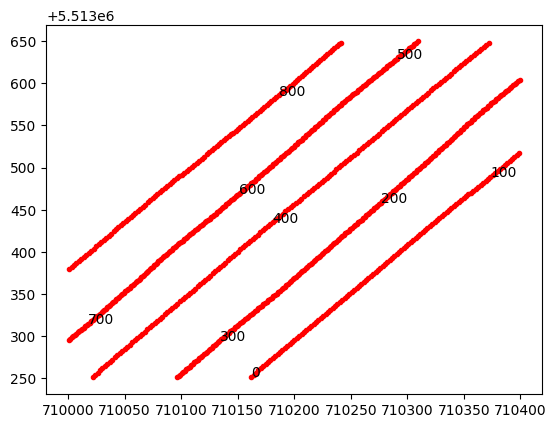

In [22]:
plot_survey_map(survey_setup)

In [23]:
print(n_fiducials)

828


In [24]:
## Decimate data by a factor 
q=10
survey_setup, system_spec, data_obs = get_subset_of_survey(
    survey_setup, system_spec, data_obs, gate_idx=None,fiducial_id=numpy.arange(0,n_fiducials,q)
)

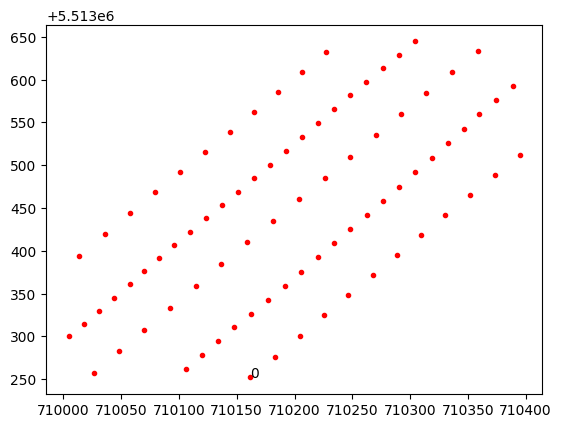

In [25]:
plot_survey_map(survey_setup)

In [26]:
with open('caber_survey.npy', 'wb') as f:
    numpy.save(f,survey_setup,allow_pickle=True)
    numpy.save(f,system_spec,allow_pickle=True)
    numpy.save(f,numpy.log(data_obs*1e6),allow_pickle=True)

---
## Watermark

<!-- Feel free to add more modules in the watermark_list below, if more packages are used -->
<!-- Otherwise please leave the below code cell unchanged -->

In [27]:
watermark_list = ["cofi", "numpy", "scipy", "matplotlib"]
for pkg in watermark_list:
    pkg_var = __import__(pkg)
    print(pkg, getattr(pkg_var, "__version__"))

cofi 0.2.9
numpy 2.0.1
scipy 1.14.0
matplotlib 3.9.1.post1
